
We recently built an activity recognizer with a convolutional neural network.
Recurrent neurons have state and are known to be useful with sequential data.
The purpose of this assignment is to learn to use recurrent layers in Keras and
to see whether a recurrent network can outperform a convolutional network.

## Instructions:
- Add your own code to the end of this notebook.
- Use X_test and y_test only to report your final test accuracy.  For example, don't use X_test and y_test in training.
- You are to work completely on your own, and to not look at solutions on the web.  You may look at the Chollet book for code examples; see especially Section 10.3.
- See the assignment google doc for further instructions.


In [ ]:
import numpy as np
from scipy.signal import find_peaks, periodogram
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from tensorflow.keras import models, layers
from tensorflow.keras import backend as K

In [ ]:
def plot_metric(history, metric='loss'):
    """ Plot training and test values for a metric. """

    val_metric = 'val_'+metric
    plt.plot(history.history[metric])
    plt.plot(history.history[val_metric])
    plt.title('model '+metric)
    plt.ylabel(metric)
    plt.xlabel('epoch')
    plt.legend(['train', 'test'])
    plt.show();

In [ ]:
np.random.seed(0)

### Read data and perform basic preprocessing

In [ ]:
# Load data for a single user.  Users are numbered 1-15.
infile = 'https://raw.githubusercontent.com/grbruns/cst383/master/activity-4.csv'
df = pd.read_csv(infile, index_col=0, header=None)

df.columns = ['x', 'y', 'z', 'activity']
df = df[df['activity'] != 0]
df['activity'] = df['activity'] - 1
activity_names = ['desk', 'mixed', 'standing', 'walking', 'stairs', 'talking/walking', 'talking/standing']

### Initial exploration

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 122200 entries, 0.0 to 122200.0
Data columns (total 4 columns):
 #   Column    Non-Null Count   Dtype
---  ------    --------------   -----
 0   x         122200 non-null  int64
 1   y         122200 non-null  int64
 2   z         122200 non-null  int64
 3   activity  122200 non-null  int64
dtypes: int64(4)
memory usage: 4.7 MB


In [ ]:
df.describe()

,x,y,z,activity
count,122200.000000,122200.000000,122200.000000,122200.000000
mean,2053.151088,2377.315164,2024.087070,2.904992
std,51.148136,56.854804,46.609623,2.313771
min,1132.000000,1649.000000,878.000000,0.000000
25%,2019.000000,2369.000000,2007.000000,0.000000
50%,2053.000000,2380.000000,2025.000000,3.000000
75%,2081.000000,2387.000000,2034.000000,6.000000
max,2723.000000,3046.000000,2954.000000,6.000000


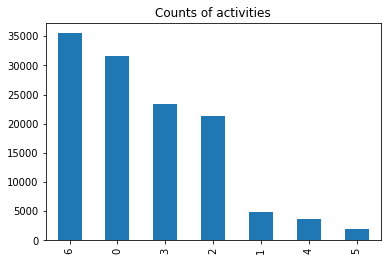

In [ ]:
df['activity'].value_counts().plot.bar()
plt.title('Counts of activities');

### Data preparation

In [ ]:
def create_segments(X, window_size, shift):
    """ Return a list of NumPy arrays, each a segment.
    
    X is a numpy array with shape (number of time steps, number of variables)
    window_size defines the size of the segments
    shift is the number of time steps to shift the window
    
    The output is a NumPy array with shape (k, window_size, n)
    """

    # compute number of segments in X
    # X.shape[0]/shift gives total number of window positions
    num_segments = np.floor(X.shape[0]/shift) - np.ceil(window_size/shift)
    num_segments = int(num_segments)
    
    # create the segments
    segments = np.zeros((num_segments, window_size, X.shape[1]))
    for i in np.arange(num_segments):
        segments[i, :, :] = X[(i*shift):(i*shift + window_size), :]
        
    return segments

In [ ]:
def clean_and_label(segments):
    """ From the given segments, create a new array of the clean segments.
    Return the clean segments, with activity values removed, 
    and an activity label for each.
    """

    # compute number of single class ("clean") segments
    n = segments.shape[0]
    num_clean = 0
    for i in range(n):
        segment_classes = segments[i,:,3]
        if segment_classes.min() == segment_classes.max():
            num_clean += 1
    
    print('fraction of segments with a single class: {:.3f}'.format(num_clean/n))
    
    # create clean segments, and create training labels
    segs = np.zeros((num_clean, segments.shape[1], segments.shape[2]-1))
    y = np.full(num_clean, 0)
    idx = 0
    for i in range(n):
        segment_classes = segments[i,:,3]
        if segment_classes.min() == segment_classes.max():
            segs[idx,:,:] = segments[i,:,:3]
            y[idx] = segment_classes[0]
            idx += 1
            
    return segs, y

#### Create raw segments from data

Each segment can have multiple class labels associated with it.

In [ ]:
window_size = 100
shift = 10
segments = create_segments(df.values, window_size, shift)
X, y = clean_and_label(segments)

fraction of segments with a single class: 0.994


In [ ]:
print(X.shape)
print(y.shape)

(12137, 100, 3)
(12137,)


Plot a random clean segment.

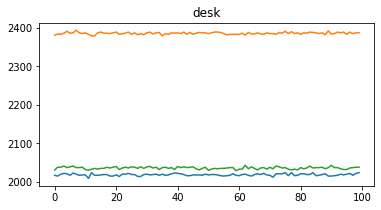

In [ ]:
plt.figure(figsize=(6,3))
i = np.random.choice(X.shape[0])
plt.plot(X[i])
plt.title(activity_names[y[i]]);

### Prepare data for machine learning

Perform any further preprocessing, then do a train/test split.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(8495, 100, 3) (8495,)
(3642, 100, 3) (3642,)


Check the target values.

In [ ]:
print(np.unique(y_train, return_counts=True))
print(np.unique(y_test, return_counts=True))

(array([0, 1, 2, 3, 4, 5, 6]), array([2190,  333, 1443, 1621,  263,  131, 2514]))
(array([0, 1, 2, 3, 4, 5, 6]), array([ 955,  139,  670,  700,  102,   51, 1025]))


### Machine learning

The goal is to predict the activity of a training example.  This is a multi-class classification problem.

In [ ]:
# to get baseline accuracy, always predict the most common activity
counts = df['activity'].value_counts()/df.shape[0]
print('baseline accuracy: {:0.4f}'.format(counts[0]))

baseline accuracy: 0.2581


This is to help ensure that a standard data set is being used.

In [ ]:
print(X_train.shape, y_train.shape)
print(X_train.sum(), X_test.sum())

(8495, 100, 3) (8495,)
5483020712.0 2350871716.0


#### Recurrent models

In [ ]:
# delete any old models
K.clear_session()

Add your cells here.

Don't forgot to compute and print the test accuracy of your best model at the end of the notebook.